In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from environments.base_env import HomeostaticEnvironment
from environments.anticipatory_env import AnticipatoryEnvironment
from models.qlearning import QLearning
import numpy as np

# Test base_env 

In [3]:
import torch
# Définir les paramètres
initial_state = [90, 37]  # Glucose = 90, Température = 37
setpoints = [100, 37]  # Setpoints pour le glucose et la température
weights = [1, 2]  # Importance relative : température plus critique
exponents = [2, 2]  # Non-linéarité pour les calculs de drive
effects = {
    "eat": [10, 0],  # Manger augmente le glucose de 10
    "cool_down": [0, -2]  # Se refroidir réduit la température de 2
}

# Instancier l'environnement
env = HomeostaticEnvironment(H=initial_state, setpoints=setpoints, weights=weights, exponents=exponents, effects=effects)

# Test de l'environnement
print("État initial :", env.state)

# Effectuer une action ("eat")
state, reward,_,_ = env.step("eat")
print("État après manger :", state)
print("Récompense :", reward)

# Effectuer une autre action ("cool_down")
state, reward,_,_ = env.step("cool_down")
print("État après refroidissement :", state)
print("Récompense :", reward)


État initial : tensor([90., 37.])
État après manger : tensor([100.,  37.])
Récompense : tensor(0.)
État après refroidissement : tensor([100.,  35.])
Récompense : tensor(-2.8284)


# Test Experience Anticipation avec QLearning 

In [4]:
# Paramètres
state_size = 3  # la température
action_size = None # Nombre d'actions possibles mais les actions possible sont different selon les etats
alpha = 0.2 # Taux d'apprentissage
gamma = 0.96 # Discount factor
epsilon = 0.1 # Facteur d'exploration
max_epoch = 1000  # Nombre d'épisodes

Q_table = {
    0: np.zeros(2),  # Etat initial avec 2 actions qui sont anticiper et ne pas anticiper
    1: np.zeros(1),  # Etat ou l'agent a anticipé
    2: np.zeros(1),  # Etat ou l'agent n'a pas anticipé
    3: np.zeros(1),  # Etat terminal
}

# Instancier le modèle Q-learning
agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, epsilon=epsilon, q_table=Q_table)


In [5]:
# Définition des paramètres de l'environnement
initial_state = torch.tensor([37.0])  # Température corporelle initiale
setpoints = torch.tensor([37.0])  # Température optimale
weights = torch.tensor([1.0])  # Importance de la température
exponents = [2, 4]  # Non-linéarité / Parametres de drive
effects = {
    # Pas d'effet sur la température de maniere flat, donc gestion dans specifique l'environnment
}
signal_timesteps = [0]
injection_timesteps = [2]
max_timestep = 24 # 30 minutes = 0.5 timestep, ==> 24 heures = 24 timesteps

# Instanciation de l'environnement
env = AnticipatoryEnvironment(
    H=initial_state,
    setpoints=setpoints,
    weights=weights,
    exponents=exponents,
    effects=effects,
    signal_timesteps=signal_timesteps,
    injection_timesteps=injection_timesteps,
    max_timestep=max_timestep
)


In [6]:
markov_state, reward, done, _ = env.step(0)

Offset at 0: tensor([37.]), anticipation: 0.0, injection: 0.0


Offset at 0: tensor([37.]), anticipation: 0.0, injection: 0.0
Markov state : 0 Reward : 0.0
Offset at 0.5: tensor([37.3000]), anticipation: 0.30000001192092896, injection: 0.0
Markov state : 1 Reward : -0.5477218627929688
Offset at 1.0: tensor([37.5200]), anticipation: 0.5199999809265137, injection: 0.0
Markov state : 1 Reward : -0.7211105823516846
Offset at 1.5: tensor([36.6400]), anticipation: 0.6899999976158142, injection: -1.0499999523162842
Markov state : 1 Reward : -0.6000005006790161
Offset at 2.0: tensor([36.4400]), anticipation: 0.8199999928474426, injection: -1.3799999952316284
Markov state : 1 Reward : -0.7483323812484741
Offset at 2.5: tensor([36.5500]), anticipation: 0.9100000262260437, injection: -1.3600000143051147
Markov state : 1 Reward : -0.670820951461792
Offset at 3.0: tensor([36.7200]), anticipation: 0.9800000190734863, injection: -1.2599999904632568
Markov state : 1 Reward : -0.5291491150856018
Offset at 3.5: tensor([36.9200]), anticipation: 1.0399999618530273, in

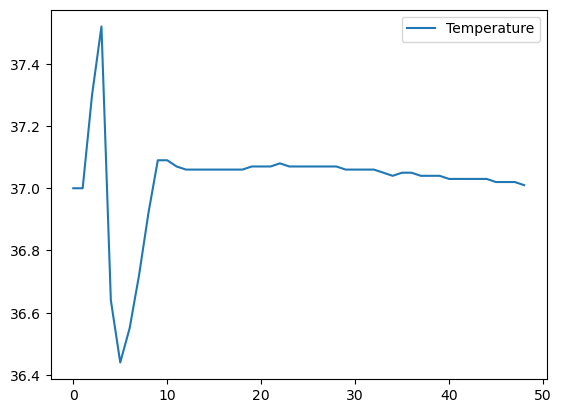

In [7]:
env.reset()
internal_states = []
internal_state, markov_state = env.reset()
done = False
total_reward = 0
internal_states = [internal_state.clone()]
while not done:
    action = 1
    internal_state, reward, done, next_markov_state = env.step(action)
    print(f"Markov state : {markov_state} Reward : {reward}")
    markov_state = next_markov_state
    total_reward += reward
    internal_states.append(internal_state.clone())

# Affichage de l'évolution de la température
import matplotlib.pyplot as plt


plt.plot(internal_states, label="Temperature")
plt.legend()
plt.show()

Offset at 0: tensor([37.]), anticipation: 0.0, injection: 0.0
Markov state : 0 Reward : 0.0
Offset at 0.5: tensor([37.3000]), anticipation: 0.30000001192092896, injection: 0.0
Markov state : 1 Reward : -0.5477218627929688
Offset at 1.0: tensor([37.5200]), anticipation: 0.5199999809265137, injection: 0.0
Markov state : 1 Reward : -0.7211105823516846
Offset at 1.5: tensor([36.6400]), anticipation: 0.6899999976158142, injection: -1.0499999523162842
Markov state : 1 Reward : -0.6000005006790161
Offset at 2.0: tensor([36.4400]), anticipation: 0.8199999928474426, injection: -1.3799999952316284
Markov state : 1 Reward : -0.7483323812484741
Offset at 2.5: tensor([36.5500]), anticipation: 0.9100000262260437, injection: -1.3600000143051147
Markov state : 1 Reward : -0.670820951461792
Offset at 3.0: tensor([36.7200]), anticipation: 0.9800000190734863, injection: -1.2599999904632568
Markov state : 1 Reward : -0.5291491150856018
Offset at 3.5: tensor([36.9200]), anticipation: 1.0399999618530273, in

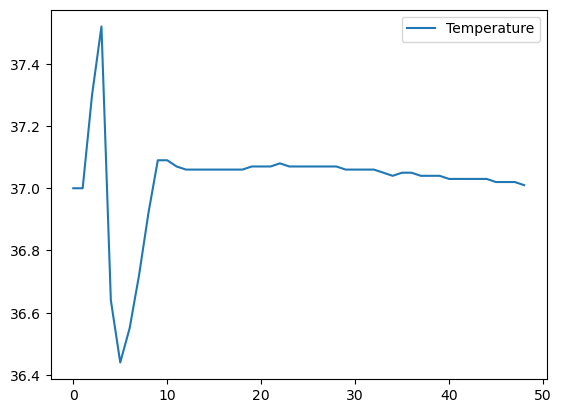

In [8]:
env.reset()
internal_states = []
internal_state, markov_state = env.reset()
done = False
total_reward = 0
internal_states = [internal_state.clone()]
first = True
while not done:
    if first:
        action = 1
    else:
        action = 0
    internal_state, reward, done, next_markov_state = env.step(action)
    print(f"Markov state : {markov_state} Reward : {reward}")
    markov_state = next_markov_state
    total_reward += reward
    internal_states.append(internal_state.clone())

# Affichage de l'évolution de la température
import matplotlib.pyplot as plt


plt.plot(internal_states, label="Temperature")
plt.legend()
plt.show()

Epoch 0 - Total reward : -13.184142112731934
Epoch 1 - Total reward : -13.184142112731934
Epoch 2 - Total reward : -21.408206939697266
Epoch 3 - Total reward : -13.184142112731934
Epoch 4 - Total reward : -21.408206939697266
Epoch 5 - Total reward : -13.184142112731934
Epoch 6 - Total reward : -13.184142112731934
Epoch 7 - Total reward : -13.184142112731934
Epoch 8 - Total reward : -13.184142112731934
Epoch 9 - Total reward : -13.184142112731934
Epoch 10 - Total reward : -13.184142112731934
Epoch 11 - Total reward : -13.184142112731934
Epoch 12 - Total reward : -13.184142112731934
Epoch 13 - Total reward : -21.408206939697266
Epoch 14 - Total reward : -13.184142112731934
Epoch 15 - Total reward : -13.184142112731934
Epoch 16 - Total reward : -13.184142112731934
Epoch 17 - Total reward : -13.184142112731934
Epoch 18 - Total reward : -13.184142112731934
Epoch 19 - Total reward : -13.184142112731934
Epoch 20 - Total reward : -13.184142112731934
Epoch 21 - Total reward : -13.18414211273193

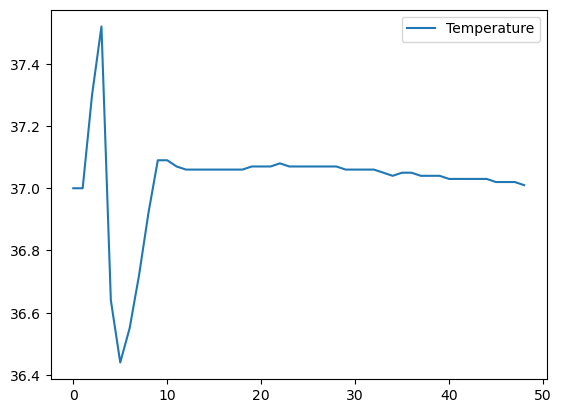

In [14]:
# Boucle Q-learning

# Override max_epoch to 1 for testing
max_epoch = 1000

env.reset()
for epoch in range(max_epoch):
    internal_states = []
    internal_state, markov_state = env.reset()
    done = False
    total_reward = 0
    internal_states = [internal_state.clone()]
    while not done:
        action = agent.choose_action(markov_state)
        internal_state, reward, done, next_markov_state = env.step(action)
        agent.update_q_value(markov_state, action, reward, next_markov_state)
        markov_state = next_markov_state
        total_reward += reward
        internal_states.append(internal_state.clone())
    print(f"Epoch {epoch} - Total reward : {total_reward}")

# Affichage de l'évolution de la température
import matplotlib.pyplot as plt


plt.plot(internal_states, label="Temperature")
plt.legend()
plt.show()


In [12]:
agent_q_table = agent.q_table
for state, actions in agent_q_table.items():
    print(f"State {state} : {actions}")

State 0 : [-10.22370625  -6.45241499]
State 1 : [-6.72126675]
State 2 : [-10.64970112]
State 3 : [0.]
